In [55]:
# enables autoreloading modules
# means that if changes made in referenced .py files, the jupyter nb doesnt need to be restarted
# !! unfortunately: This cell needs to be reloaded when changes made to the bootstrap in bootstrap.py (still better than restarting)
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from bootstrap import Bootstrap, MonteCarlo

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Synthetic Data Example (Franke & Halim, 2007)

No Defects: $H_0: m_I = m_{II}$

The Hypothesis H0 was not rejected
c_alpha_star is 3.4839


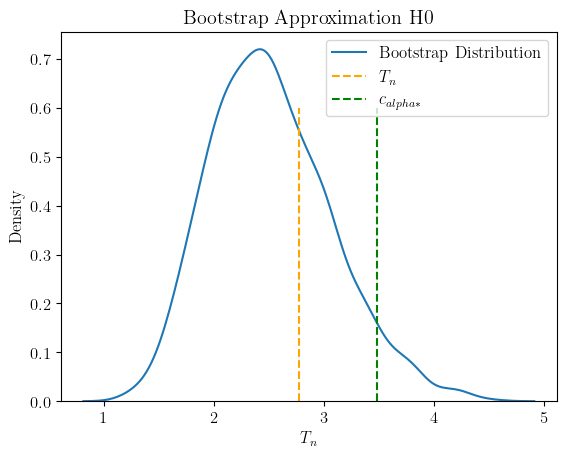

In [60]:
# Generate observational data
y1, y2 = generate_data_franke(defect=False)

BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
results_H0 =BS.compute(y1, y2, h=.02, g=.03, B=1000, alpha=.05)
fig = BS.plot_kde(title="Bootstrap Approximation H0")
fig.savefig("plots/Bootstrap Approximation H0.pdf", bbox_inches="tight", pad_inches=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 252.32it/s]


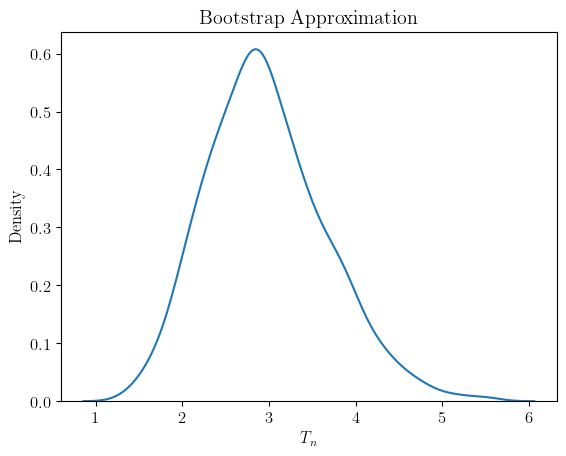

In [61]:
MC = MonteCarlo(kernel_function="bartlett_priestley_kernel")
Tn_monte = MC.compute_Tn(h=.02, M=1000)

# run & plot
fig, ax = plt.subplots()
sns.kdeplot(Tn_monte, ax=ax)
ax.set_xlabel(r"$T_n$")
ax.set_title("Bootstrap Approximation")
plt.show()

Defects: $H_1: m_I$ != $m_{II}$

The Hypothesis H0 was rejected
c_alpha_star is 3.8349


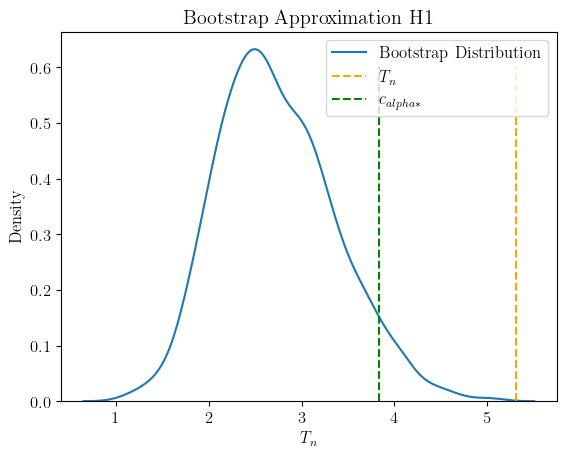

In [63]:
# Generate observational data
y1, y2 = generate_data_franke(defect=True)

BS = Bootstrap(method="wild", kernel_function="bartlett_priestley_kernel")
results_H1 = BS.compute(y1, y2, h=.02, g=.03, B=1000, alpha=.05)
fig = BS.plot_kde(title="Bootstrap Approximation H1")
fig.savefig("plots/Bootstrap Approximation H1.pdf", bbox_inches="tight", pad_inches=0.1)

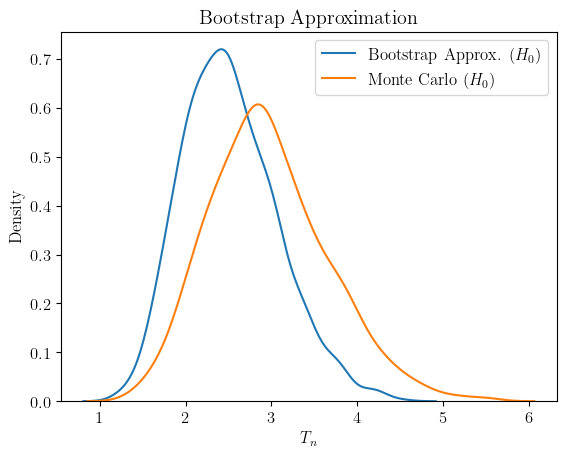

In [64]:
fig, ax = plt.subplots()
sns.kdeplot(results_H0["Tn_star"], ax=ax, label=r"Bootstrap Approx. ($H_0$)")
sns.kdeplot(Tn_monte, ax=ax, label=r"Monte Carlo ($H_0$)")
#sns.kdeplot(results_H1["Tn_star"], ax=ax, label=r"Bootstrap Approx. ($H_1$)")
#ax.vlines(results_H0["Tn"], ymin=0, ymax=.6, linestyles="dashed",colors="orange", label=r"$T_n H_0$")
#ax.vlines(results_H1["Tn"], ymin=0, ymax=.6, linestyles="dashed",colors="green", label=r"$T_n H_1$")

#sns.kdeplot(Tn_monte_H1, ax=ax, label=r"Monte Carlo ($H_1$)")
ax.set_xlabel(r"$T_n$")
ax.set_title("Bootstrap Approximation")
ax.legend()
plt.show()
fig.savefig("plots/Bootstrap Approximation H0 comparision.pdf", bbox_inches="tight", pad_inches=0.1)

# Examination

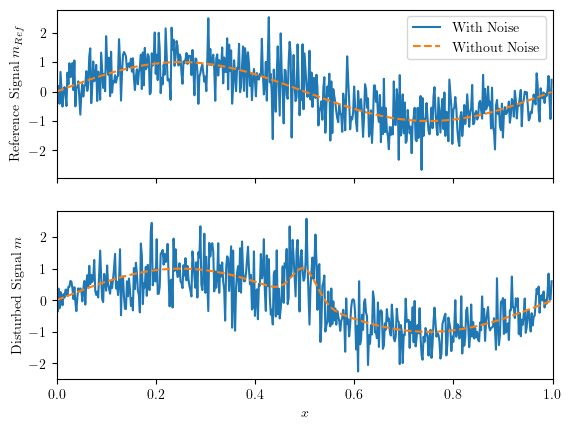

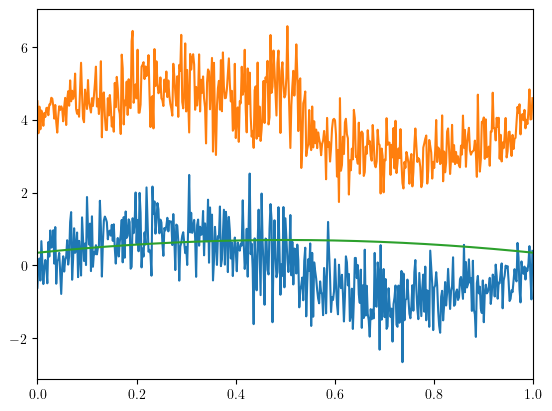

In [20]:
# plotting generated signals
N = 500
x = np.arange(N)/N
m1 = np.sin(np.pi*2*x)
m2 = np.sin(np.pi*2*x) + np.exp((-800)*np.power(x-0.5, 2))
sigma = 0.7 - 1.4*np.square(x-0.5)
y1, y2 = generate_synthetic_data(m1, m2, sigma)
y1_clean, y2_clean = generate_synthetic_data(m1, m2, 0)

#plt.figure(dpi=600)
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(x, y1)
axs[0].plot(x, y1_clean, "--")
axs[0].set_ylabel(r"Reference Signal $m_{Ref}$")
axs[1].plot(x, y2)
axs[1].plot(x, y2_clean, "--")
axs[1].set_ylabel(r"Disturbed Signal $m$")
axs[1].set_xlabel(r"$x$")
axs[0].legend(["With Noise", "Without Noise"])
plt.xlim([0, 1])
plt.savefig("plots/Signals.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


plt.plot(x, y1)
plt.plot(x, y2+4)
plt.plot(x, sigma)
plt.xlim([0, 1])
plt.show()

In [53]:
bartlett.shape, gauss.shape

((80,), (80,))

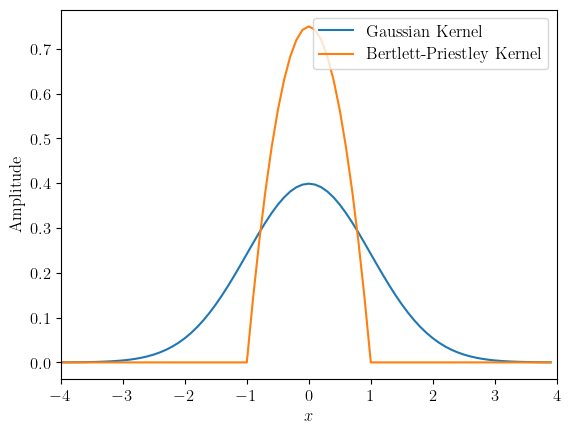

In [65]:
x = np.arange(-4, 4, .1)
h = 1
gauss = gaussian_kernel(x, h)
bartlett = bartlett_priestley_kernel(x, h)
#plt.figure(dpi=600)
fig, ax = plt.subplots()
ax.plot(x, gauss, label="Gaussian Kernel")
ax.plot(x, bartlett, label="Bertlett-Priestley Kernel")
ax.set_ylabel(r"Amplitude")
ax.set_xlabel(r"$x$")
ax.legend()
plt.xlim([-4, 4])
plt.savefig("plots/Kernels.pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()

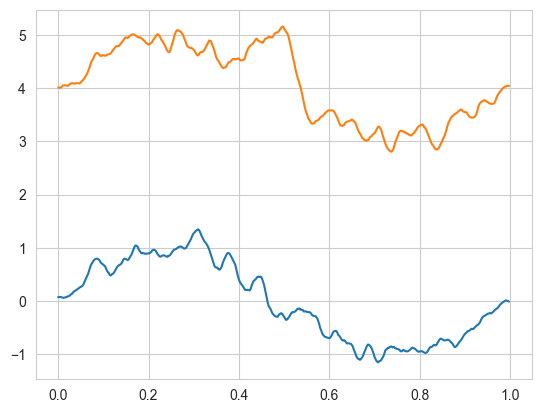

In [26]:
# plotting smoothed estimates
m1 = calc_smoothed_estimate(y1, bartlett_priestley_kernel, h=0.02)
m2 = calc_smoothed_estimate(y2, bartlett_priestley_kernel, h=0.02)
plt.plot(x, m1)
plt.plot(x, m2+4)
# plt.plot(x,np.square(m1-m2))
# np.sum(np.square(m1-m2))*np.sqrt(0.02)
plt.show()

# Test 2D Image

In [160]:
folders = ["no_defect_images", "defect_images"]
X,X_hat = load_images(folders, target_size=(100, 100), detrend=False)
y = X_hat[1]

Processing Rows: 5it [00:00, 49.10it/s]

Processing Rows: 100it [00:00, 179.56it/s]
Processing Columns: 100it [00:00, 196.05it/s]


[False False False False False False False False False False False False
 False False False False False False False False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False] [False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False 

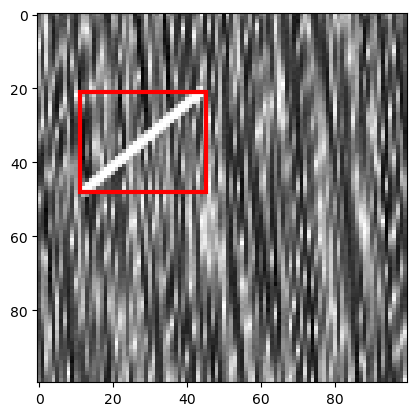

In [163]:
# h_r = 0.005 h_c = 0.01 kernel_function="gaussian_kernel"

h_r = 0.005
h_c = 0.01
factor = 10
BS = Bootstrap(method="wild", kernel_function="gaussian_kernel")
defect, minpoint, maxpoint = BS.test_image(X[0],y, B=500, h=(h_r, h_c), g=(h_r*factor, h_c*factor))
print(defect, minpoint, maxpoint)
plot_defect_area(y, minpoint, maxpoint)

# Old Snippets

In [ ]:
epsilon_hat = np.random.random_sample(10)
x_all = np.zeros((1000000, 10))
for i in range(1000000):
    x_all[i, :] = get_wild_residual_normal(epsilon_hat)
print(np.square(epsilon_hat))
print(np.power(epsilon_hat, 3))
print(np.mean(x_all, axis=0))
print(np.mean(np.square(x_all), axis=0))
print(np.mean(np.power(x_all, 3), axis=0))

In [ ]:
import matplotlib.pyplot as plt 
N = 500
x = np.arange(N)/N
y = np.sin(np.pi * 2* x) + np.exp((-800)*np.power(x-0.5, 2))
m = smoothed_estimate(y, bartlett_priestley_kernel, h=0.2)

plt.figure(dpi=600)
plt.plot(x, y)
plt.plot(x, m)
plt.title("Test for smoothed estimate")
plt.legend(["y", "m"])
plt.show()